# Predictive Modeling w/ PyTorch
This notebook is a work-in-progress.

- Code to predict stock market movements with large scale technical indicator data used in PyTorch layers.
- Model choice will likely be LSTM but TBD.
- The original data is 'close' pricing and daily 'volume'. These are further extended with many technical indicators.
- The technical indicator data is then pulled for stocks that have close correlations in return with a 'given' input ticker.
- Data for several of these tickers (and their corrs) is then concatenated to construct training dataset.
- In-progress: Train and test in PyTorch NN layers

In [ ]:
import os
import os.path
from datetime import datetime
from typing import Union, Any

import pandas as pd
from pandas.errors import EmptyDataError
from sqlalchemy import create_engine, text
from sklearn.preprocessing import MinMaxScaler

from functools import reduce

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
pd.options.mode.chained_assignment = None

In [ ]:
BASE_DIR = '../../../../workspace/HelloPython/HistoricalMarketData/TechnicalIndicators'
TABLE_EQUITIES_DATA = 'equities_historic_data'
DURATIONS = (14, 30, 90, 200)  # Roughly for bi-weekly, monthly, quarterly, and 200 days running averages

In [ ]:
try:
    DB = os.environ["DB"]
    DB_USER = os.environ["DB_USER"]
    DB_PWD = os.environ["DB_PWD"]
except KeyError:
    raise Exception("Required environment variables DB_USER and DB_PWD not set")
DB_URL = 'mysql+mysqlconnector://' + DB_USER + ':' + DB_PWD + '@localhost/' + DB
ENGINE = create_engine(DB_URL)

In [ ]:
def generate_file_path(symbol, date=None):
    """
    Generates a file path for a given symbol
    to retrieve calculated tech indicator data
    from local CSV records
    :param symbol: ticker
    :param date: date embedded in the file name
    :return: file name and path
    """
    if date is not None:
        str_date = datetime.strftime(date, '%Y%m%d')
        file_name = symbol.lower() + '_' + str_date + '.csv'
    else:
        file_name = symbol.lower() + '.csv'
    file_path = os.path.join(BASE_DIR, file_name)
    if file_path is None:
        print('Could not find file for symbol:{}'.format(symbol))
    # print(file_path)
    return file_path, file_name

In [ ]:
def retrieve_technical_indicator_data_for_symbol(symbol, columns = None, feature=None)\
        -> Any:
    """
    Retrieves Technical Indicator Data for a given symbol
    for given columns and labels them as Y (dependent) or
    X (input features).
    :param symbol: Symbol for which to retrieve Technical Indicator Data
    :param columns: Subset of Technical Indicator Data to retrieve
    :param feature: Y or X_i label where 'i' is feature number
    :return:
    """
    file_path, _ = generate_file_path(symbol)
    if file_path is not None:
        try:
            dfrm = pd.read_csv(file_path)
            dfrm['date'] = pd.to_datetime(dfrm['date'])
            dfrm.set_index('date', inplace=True)
            dfrm.sort_index(ascending=True)
            dfrm.index.name = 'date'
            if feature is None:
                feature = symbol.upper()
            if columns is not None:
                dfrm = dfrm[columns]
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                if column in columns
                ]
            else:
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                ]
            return dfrm
        except FileNotFoundError as e:
            print('Exception reading input data for symbol {}. Generating metadata starting from baseline date.'.format(symbol.upper()))
            return None
        except EmptyDataError as e:
            print(f'No technical indicators found for {symbol.upper()}. Generating metadata starting from baseline date.')
            print('Generating all records.')
            return None
    else:
        print(f"No technical indicators data in DB for '{symbol}'.")
    return None

tmp_df = retrieve_technical_indicator_data_for_symbol('AAPL', ['volume', 'close'])
tmp_df.tail(10)

In [ ]:
def find_symbols_w_highest_correlations(symbol, correlations, count):
    """
    Finds tickers whose return have highest correlation
    with the returns of given symbol
    :param symbol:
    :param correlations:
    :param count:
    :return:
    """
    if len(correlations[correlations['level_0'] == symbol.upper()+'_close']) <= 0:
        print("No correlations found for symbol:{}.".format(symbol.upper()))
        print("Likely data does not go far enough back.")
        return None
    corrs = correlations[correlations['level_0'] == symbol.upper()+'_close']
    corrs.sort_values(0, ascending = False, inplace = True)
    return_symbols = [symbol.replace('_close', '') for symbol in corrs.loc[:,'level_1'].tolist()]
    return return_symbols[0:count]

In [ ]:
def gen_corrs(dfrm):
    """
    Generate correlations numbers for entire
    input dataframe consisting of daily close values
    :param dfrm:
    :return:
    """
    correlations = dfrm[dfrm.columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #print(correlations)`
    return correlations

## Training Dataset
Generate training dataset by finding symbols that have the highest correlation (based on daily 'close' values) with the given symbol. Then aggregate their returns over the years. The daily closing price of our target symbol becomes independent variable y and rest of the data including closing values of other symbols and their volumes make up the 'features' or 'X'.

In [ ]:
MIN_ROW_COUNT = 5000 # Number of days to retrieve training data for
COMP_COUNT = 10 # Number of stocks to find high correlations with

query = 'SELECT symbol FROM equities_historic_data GROUP BY symbol HAVING COUNT(*) > '+str(MIN_ROW_COUNT)+''
with ENGINE.connect() as conn:
    res = conn.execute(text(query))
dfrm_symbols_list = pd.DataFrame(res.mappings().all())
symbols = dfrm_symbols_list['symbol'].tolist() # this is our universe of symbol tickers

# First calculate universal correlations among ALL these symbols
dfrm_list_daily_closes = list()
for symbol in symbols:
    dfrm = retrieve_technical_indicator_data_for_symbol(symbol, ['close', 'volume'])
    dfrm_list_daily_closes.append(dfrm)
merged_dfrm_daily_close_values = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_daily_closes)
correlations = gen_corrs(merged_dfrm_daily_close_values)

# Now merge a symbol's returns with returns of symbols
# it has the highest correlations with. Then stack (concat)
# all these returns across symbols to come up with our
# training dataset

# Data for a symbol and its corrs matches
# Think of this as a single line in a matrix
dfrm_list_single_row_data = list()
# Data for all symbol and their corrs matches
# Think of this as a matrix
dfrm_list_full_matrix_data = list() # Data for
tgt_symbols_list = ['JPM', 'C', 'MS', 'GS', 'WFC', 'BAC'] # Generate training data for this set only
for symbol in tgt_symbols_list:
    # Our dependent variable Y - generalize the name so we can stack up many symbols for training dataset
    dfrm_symbol = retrieve_technical_indicator_data_for_symbol(symbol, None, 'Y')
    dfrm_list_single_row_data.append(dfrm_symbol)
    symbols_w_highest_corrs = find_symbols_w_highest_correlations(symbol, correlations, COMP_COUNT)
    if symbols_w_highest_corrs is None:
        continue # Likely not enough data for a symbol. Continue with rest
    print(f'Symbols with highest correlations with {symbol.upper()} are {symbols_w_highest_corrs}')
    counter = 1
    for comp_symbol in symbols_w_highest_corrs:
        feature = 'X_'+str(counter)
        dfrm_tmp = retrieve_technical_indicator_data_for_symbol(comp_symbol, None, feature)
        dfrm_list_single_row_data.append(dfrm_tmp)
        counter += 1
    # Now merge the symbol and all its corrs data against the same date
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_single_row_data)
    dfrm_list_full_matrix_data.append(merged_df)
    dfrm_list_single_row_data.clear()
# Now concatenate data. This means dates are repeated
dfrm_aggr_training_data = pd.concat(dfrm_list_full_matrix_data)

In [ ]:
dfrm_single_symbol_training_data = dfrm_list_full_matrix_data[4]
dfrm_single_symbol_training_data

## Data Normalization and Train-Test split

In [ ]:
# Start with separating independent vector matrix (X) and dependent vector (y)
# Take care of X first
batch_size = 5
len_data = len(dfrm_single_symbol_training_data)
tgt_field_column_name = 'Y_close'
tgt_symbol_column_name = 'Y_symbol'
train_to_total_ratio = 0.8
test_to_total_ratio = 1- train_to_total_ratio

# The train and test dataset must be perfect multiple of batch size
# Try to find some API to simplify this.
offset_test_data_start = len_data - int(test_to_total_ratio * len_data)
offset_test_data_start = offset_test_data_start - (offset_test_data_start % batch_size)
offset_test_date_end = offset_test_data_start + int(test_to_total_ratio * len_data)
offset_test_date_end = offset_test_date_end - (offset_test_date_end % batch_size)

dfrm_training = dfrm_single_symbol_training_data.iloc[batch_size:offset_test_data_start, :]
dfrm_test = dfrm_single_symbol_training_data.iloc[offset_test_data_start:offset_test_date_end, :]
print(len(dfrm_training))
print(len(dfrm_test))

In [ ]:
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column]
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Cap the numeric values within (-1, +1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler.fit_transform(Y_test.values.reshape(-1,1))

transformed_X_train = X_train.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_train.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_train[column_name] = scaler.fit_transform(X_train[[column_name]])

transformed_X_test = X_test.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
for column_name in X_test.select_dtypes(include=['int64', 'float64']).columns:
    transformed_X_test[column_name] = scaler.fit_transform(X_test[[column_name]])

In [ ]:
x_train = torch.from_numpy(transformed_X_train.to_numpy()).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test.to_numpy()).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

In [40]:
input_dim = len(X_train.columns) # Number of features
hidden_dim = int(len(X_train)/batch_size) # Number of samples or units
num_layers = 2
output_dim = 1
num_epochs = 2 # Intentionally keeping low for initial debugging

## Model Definition and Precitions

In [41]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # The tensor will be (batch_size, hidden_dim, input_dim) in that order
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        if len(x.shape) == 2:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        # print(f'X:{x}')
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [42]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers= num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [43]:
model.lstm.all_weights

[[Parameter containing:
  tensor([[ 0.0183,  0.0160, -0.0165,  ..., -0.0196,  0.0021,  0.0003],
          [ 0.0279, -0.0209,  0.0055,  ..., -0.0178, -0.0103,  0.0014],
          [ 0.0197,  0.0210,  0.0243,  ..., -0.0180, -0.0033,  0.0011],
          ...,
          [ 0.0238, -0.0143, -0.0064,  ...,  0.0216, -0.0256, -0.0318],
          [ 0.0271,  0.0196,  0.0142,  ...,  0.0195, -0.0214, -0.0088],
          [-0.0070,  0.0247, -0.0138,  ..., -0.0297,  0.0114, -0.0133]],
         requires_grad=True),
  Parameter containing:
  tensor([[-0.0327, -0.0070, -0.0232,  ...,  0.0026, -0.0306, -0.0149],
          [ 0.0254, -0.0313,  0.0016,  ..., -0.0014,  0.0310,  0.0300],
          [-0.0309,  0.0160, -0.0118,  ...,  0.0247,  0.0005, -0.0162],
          ...,
          [ 0.0068, -0.0032,  0.0146,  ..., -0.0290,  0.0225, -0.0244],
          [ 0.0122, -0.0154,  0.0183,  ..., -0.0228,  0.0257,  0.0309],
          [-0.0119, -0.0099,  0.0259,  ..., -0.0127,  0.0170,  0.0239]],
         requires_grad=Tru

In [44]:
import time
import numpy as np
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
data_loader = DataLoader(x_train, batch_size=5, shuffle=False) # Keep shuffle false to preserve the direction
for t in range(num_epochs):
    counter = 0
    for batch in data_loader:
        #x = batch[0]
        y_train_pred = model(batch)
        loss = criterion(y_train_pred, y_train)
        # if (t + 1) % 10 == 0:
        # print(f'Epoch [{t+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        counter += 1
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

/Users/peeyushsharma/opt/anaconda3/envs/llm_venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4650, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0, Batch:0, Loss: 0.1574
Epoch:0, Batch:1, Loss: 14.1320
Epoch:0, Batch:2, Loss: 1.1840
Epoch:0, Batch:3, Loss: 15.1067
Epoch:0, Batch:4, Loss: 5.0279
Epoch:0, Batch:5, Loss: 0.1599
Epoch:0, Batch:6, Loss: 4.4114
Epoch:0, Batch:7, Loss: 6.6604
Epoch:0, Batch:8, Loss: 3.7734
Epoch:0, Batch:9, Loss: 0.5993
Epoch:0, Batch:10, Loss: 0.6092
Epoch:0, Batch:11, Loss: 2.7441
Epoch:0, Batch:12, Loss: 3.5775
Epoch:0, Batch:13, Loss: 2.2389
Epoch:0, Batch:14, Loss: 0.5415
Epoch:0, Batch:15, Loss: 0.2613
Epoch:0, Batch:16, Loss: 1.3008
Epoch:0, Batch:17, Loss: 2.0564
Epoch:0, Batch:18, Loss: 1.6459
Epoch:0, Batch:19, Loss: 0.6457
Epoch:0, Batch:20, Loss: 0.1575
Epoch:0, Batch:21, Loss: 0.5485
Epoch:0, Batch:22, Loss: 1.1508
Epoch:0, Batch:23, Loss: 1.1777
Epoch:0, Batch:24, Loss: 0.6423
Epoch:0, Batch:25, Loss: 0.1924
Epoch:0, Batch:26, Loss: 0.2716
Epoch:0, Batch:27, Loss: 0.6524
Epoch:0, Batch:28, Loss: 0.7979
Epoch:0, Batch:29, Loss: 0.5411
Epoch:0, Batch:30, Loss: 0.2179
Epoch:0, Batch:3

In [46]:
X_train

,X_1_close,X_2_close,X_3_close,X_4_close,X_5_close,X_6_close,X_7_close,X_8_close,X_9_close,X_10_close
date,,,,,,,,,,
2002-02-27,10.965,23.910,25.600,59.20,34.33,27.68,46.090,25.399,57.87,74.89
2002-02-28,10.965,22.678,25.675,58.94,34.45,27.20,46.770,25.582,57.98,75.10
2002-03-01,11.101,23.654,26.300,59.00,34.34,31.00,47.255,25.504,58.53,75.89
2002-03-04,11.438,23.230,27.145,59.99,34.95,32.71,48.605,23.849,59.88,78.09
2002-03-05,11.144,23.703,26.205,59.26,34.45,31.95,47.525,24.575,58.94,76.50
...,...,...,...,...,...,...,...,...,...,...
2020-09-02,37.610,135.390,125.980,165.78,155.16,17.95,53.930,59.010,258.12,179.46
2020-09-03,37.460,133.240,122.790,158.02,151.30,17.86,54.290,57.830,247.91,171.56
2020-09-04,38.310,131.990,122.610,160.78,151.22,17.84,54.080,57.880,248.40,168.00


In [51]:
# Make predictions
model.eval()
with torch.no_grad():
    train_predict = model(x_train)
    test_predict = model(x_test)

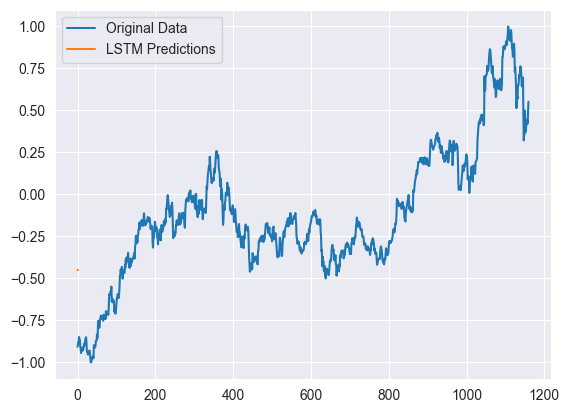

In [52]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(y_test, label='Original Data')
plt.plot(np.concatenate((train_predict.numpy().flatten(), test_predict.numpy().flatten())), label='LSTM Predictions')
plt.legend()
plt.show()